# Programmer un réseau de neurones à 2 couches

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from tqdm import tqdm

## Démarche de conception :
- Définition de la classe:
    - Concevoir un réseau de neurones multicouches avec possible `vashining gradient`. On y remédiera en utilisant un autre type de fonction d'activation (RELU OU SOFTRELU).
    - Entrées :
        - hidden_layers : un dictionnaire qui définit le nombre de noeuds de chaque couche. Exemple :
        {"hidden_layers": [`nombre_couche1`, `nombre_couche2`, ...]}. 
        - learning_rate : Le taux d'apprentissage de la descente de gradient. Plus il est élevé, plus rapidement les estimateurs des paramètres convergent.
        Attention à ne pas donner un taux d'apprentissage trop élevé ou trop faible (cause de la convergence des estimateurs).
        - epochs : Le nombre d'itérations.
    - Paramètres supplémentaires non visibles (La taille de ces paramètres peut varier suivant le nombre de hidden layers et leurs tailles) :
        - parametres : Contient les poids et les biais des différentes couches. Peut être transformer lors de la descente de gradient.
        - activations : Contient les sorties des couches cachées.
        - gradients : Contient les gradients obtenus lors de la back-propagation.
    - Méthodes :
        - initialisation(n0 [`nombre_de_variables_en_entrée`], s [`nombre_de_sorties`]) : Permet d'initialiser les paramètres (parametres)
        - forward_propagation (X_train [`donnees_d_entrainement`]) : Effectue la propagation vers l'avant. Calcule les sorties des couches cachées.
        - back-propagation (X_train [`donnees_d_entrainement`]) : Permet de calculer les gradients (le retour en arrière). La méthode est simple. Il suffit de suivres les étapes de calculs suivantes :
            1. On identifie la dernière couche. Son indice doit-être égale au nombre de couches cachées plus 1.
            2. Soit n l'indice de la dernière couche (ici la couche de sortie) et L la fonction de perte, alors ses gradients sont :
            $$
            \frac{\partial L}{\partial W_n} = \frac{1}{m}dZ_n.A_{n-1}^{\prime}, \\
            \frac{\partial L}{\partial b_n} = \frac{1}{m}\sum{dZ_n}, \\
            \text{ avec } dZ_n = (A_n - y)
            $$
            3. Les gradients de la couche n-1 sont :
            $$
            \frac{\partial L}{\partial W_{n-1}} = \frac{1}{m}dZ_{n-1}.A_{n-2}^{\prime}\\
            \frac{\partial L}{\partial b_{n-1}} = \frac{1}{m}\sum{dZ_{n-1}}\\
            \text{ avec } dZ_{n-1} = W_n^{\prime}.dZ_n\times A_{n-1}(1-A_{n-1}) 
            $$
            4. Ainsi en regardant la démarche des deux étapes précédentes : on pose $i = \{n-1,..., 2\}$ et on détermine les gradients à la couche $i$ de la manière suivante :
            $$
            \frac{\partial L}{\partial W_{i}} = \frac{1}{m}dZ_{i}.A_{i-1}^{\prime}\\
            \frac{\partial L}{\partial b_{i}} = \frac{1}{m}\sum{dZ_{i}}\\
            \text{ avec } dZ_{i} = W_{i+1}^{\prime}.dZ_{i+1}\times A_{i}(1-A_{i}) 
            $$
            5. A la couche 1 on obtient la formule suivante :
            $$
            \frac{\partial L}{\partial W_{1}} = \frac{1}{m}dZ_{1}.X^{\prime}\\
            \frac{\partial L}{\partial b_{1}} = \frac{1}{m}\sum{dZ_{1}}\\
            \text{ avec } dZ_{1} = W_{2}^{\prime}.dZ_{2}\times A_{1}(1-A_{1}) 
            $$
        - update () : Permet la mise à jour des paramètres. La procédure de mise a jour des paramètres utilisée est la descente de gradient. Elle consiste à diminuer des paramètres leur valeurs multipliées par le taux d'apprentissage (généralement un nombre décimale situé entre 0 et 1). les modifications des paramètres cessent lorsqu'on atteint le nombre maximale d'itérations. 
        - predict (X_test [`donnees_de_test`]) : Permet de déterminer les valeurs de prédiction en comparant les sorties du réseau de neurones obtenues avec les données de test avec le seuil. Un seuil de 0.5 est choisi dans ce cas précis.

In [18]:
class NeuralNetwork:
    """Un réseau de neurone multicouche
    params:
        n1 (int): Le nombre de neurones de la première couche.
        learning_rate (float): Le taux d'apprentissage de la descente de gradient. Plus il est élevé, plus rapidement les estimateurs des paramètres convergent.
        Attention à ne pas donner un taux d'apprentissage trop élevé ou trop faible (cause de la convergence des estimateurs).
        epochs (float): Le nombre d'itérations. 
    """
    def __init__(self, hidden_layers: dict, learning_rate = 0.1, epochs = 1000, decay_rate = 1):
        if type(hidden_layers["hidden_layers"]) is list:
            self.hidden_layers = hidden_layers["hidden_layers"]
        else: raise TypeError("hidden_layers['hidden_layers'] est de type list. {} fournie."\
                .format(type(hidden_layers["hidden_layers"]).__name__)) 
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.decay_rate = decay_rate
        self.network_len = len(self.hidden_layers) + 1
    
    def initialisation(self, n0, s):
        self.parametres = {}
        self.parametres["params1"] = {
            "W" : np.random.randn(self.hidden_layers[0], n0),
            "b" : np.random.randn(self.hidden_layers[0], 1)
        }
        for i in range(1, len(self.hidden_layers)):
            self.parametres[f"params{i+1}"] = {
                "W" : np.random.randn(self.hidden_layers[i], self.hidden_layers[i-1]),
                "b" : np.random.randn(self.hidden_layers[i], 1)
            }
        self.parametres[f"params{self.network_len}"] = {
            "W" : np.random.randn(s, self.hidden_layers[self.network_len-2]),
            "b" : np.random.randn(s, 1)
        }
    
    def forward_propagation(self, X_train):
        
        self.activations = {}
        W = self.parametres["params1"]["W"]
        b = self.parametres["params1"]["b"]
        Z = W.dot(X_train) + b
        A = 1 / (1 + np.exp(-Z))
        self.activations[f"activs1"] = A
        for i, key in enumerate(self.parametres.keys()):
            if i != 0:
                W = self.parametres[key]["W"]
                b = self.parametres[key]["b"]
                Z = W.dot(A) + b
                A = 1 / (1 + np.exp(-Z))
                self.activations[f"activs{i+1}"] = A
        
    
    def back_propagation(self, X_train, y_train):
        
        self.gradients = {}
        
        m = y_train.shape[1]
        
        n = self.network_len
        
        dz = self.activations[f"activs{n}"] - y_train
        
        self.gradients[f"grads{n}"] = {
            "W": (1/m)*dz.dot(self.activations[f'activs{n-1}'].T),
            "b": (1/m)*np.sum(dz, axis = 1, keepdims=True)
        }
        for i in range(n-1, 1, -1):
            
            Ai = self.activations[f"activs{i}"]
            Ai_p = self.activations[f"activs{i-1}"].T
            
            w = self.parametres[f"params{i+1}"]["W"].T
            
            dz = w.dot(dz) * Ai * (1 - Ai)
            
            self.gradients[f"grads{i}"] = {
                "W": (1/m) * dz.dot(Ai_p),
                "b": (1/m) * np.sum(dz, axis = 1, keepdims=True)
            }
            
        w = self.parametres["params2"]["W"].T
        
        A1 = self.activations["activs1"]
        
        dz = w.dot(dz) * A1 * (1 - A1)
        self.gradients[f"grads{1}"] = {
            "W": (1/m) * dz.dot(X_train.T),
            "b": (1/m) * np.sum(dz, axis = 1, keepdims=True) 
        }
    
    def update(self):
      
        for i in range(1, self.network_len+1):
            
            dw = self.gradients[f"grads{i}"]["W"]
            db = self.gradients[f"grads{i}"]["b"]
            self.parametres[f"params{i}"]["W"] -= self.learning_rate * dw
            self.parametres[f"params{i}"]["b"] -= self.learning_rate * db 
        
    def predict(self, X_test):
        self.forward_propagation(X_test)
        A = self.activations[f"activs{self.network_len}"]
        return A >= 0.5
    
    def log_loss(self, y_train):
        A = self.activations[f'activs{self.network_len}']
        m = y_train.shape[1]
        epsilon = 1e-15
        # print(A.shape, y_train.shape)
        return 1 / m * np.sum(-y_train * np.log(A + epsilon) - (1 - y_train) * np.log(1 - A + epsilon))
    
    def fit(self, X_train, X_test, y_train, y_test):
        #initialisation w, b
        n0 = X_train.shape[0]
        s = y_train.shape[0]
        self.initialisation(n0, s)
        
        train_loss = []
        train_acc = []
        test_loss = []
        test_acc = []
        for i in tqdm(range(self.epochs)):
            
            self.forward_propagation(X_train)
            self.back_propagation(X_train, y_train)
            self.update()
            
            if i % 10 ==0:
                # Train
                train_loss.append(self.log_loss(y_train))
                train_pred = self.predict(X_train)
                cur_train_accuracy = accuracy_score(y_train.flatten(), train_pred.flatten())
                train_acc.append(cur_train_accuracy)
                # test_loss.append(self.log_loss(y_test))
                test_pred = self.predict(X_test)
                cur_test_accuracy = accuracy_score(y_test.flatten(), test_pred.flatten())
                test_acc.append(cur_test_accuracy)
        plt.figure(figsize = (14, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label = "train loss")
        # plt.plot(test_loss, label = "test loss")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label = "train acc")
        plt.plot(test_acc, label = "test acc")
        plt.legend()
        plt.show()

## Dataset

In [3]:
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = False

dimensions de X: (2, 80)
dimensions de y: (1, 80)


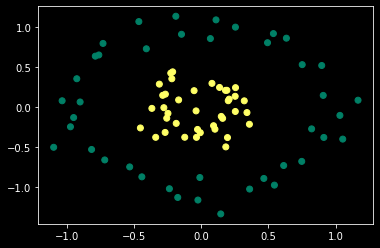

In [4]:
X, y = make_circles(n_samples=100, noise = 0.1, factor=0.3, random_state=0)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test = X_train.T, X_test.T
y_train, y_test = y_train.reshape((1, y_train.shape[0])), y_test.reshape((1, y_test.shape[0])) 

print('dimensions de X:', X_train.shape)
print('dimensions de y:', y_train.shape)

plt.scatter(X_train[0, :], X_train[1, :], c = y_train, cmap = "summer")
plt.show()

In [5]:
neural_network = NeuralNetwork({"hidden_layers": [3, 3, 3, 2]}, epochs=10000, learning_rate=0.1)

In [6]:
neural_network.network_len

5

In [7]:
neural_network.initialisation(2, 2)

In [8]:
neural_network.parametres

{'params1': {'W': array([[-0.38349372,  0.5867793 ],
         [ 1.60194186,  0.41154386],
         [ 1.43018479, -0.25047698]]),
  'b': array([[-0.25639458],
         [ 1.01561979],
         [ 2.25597272]])},
 'params2': {'W': array([[-0.36618713,  0.90765387, -0.14650578],
         [ 0.3172032 , -2.09579696,  1.34185388],
         [ 0.85068735, -0.82132621, -1.91482998]]),
  'b': array([[0.18714174],
         [1.94696124],
         [0.15711282]])},
 'params3': {'W': array([[-1.03597821,  0.03391457, -0.00768419],
         [-0.74605201, -1.5353783 ,  0.10655554],
         [ 0.88053283,  1.64041932, -0.84998323]]),
  'b': array([[0.98994354],
         [0.67575939],
         [0.26981698]])},
 'params4': {'W': array([[-0.60364508,  0.77680585, -0.91561886],
         [-0.66695459, -0.67988015,  0.1499837 ]]),
  'b': array([[-1.84764465],
         [ 0.07316245]])},
 'params5': {'W': array([[-0.4972921 ,  0.43002607],
         [ 1.35443915,  0.50546233]]),
  'b': array([[0.31808615],
       

In [1]:
# neural_network.forward_propagation(X)

In [301]:
# neural_network.activations

In [185]:
neural_network.activations["activs2"].shape

(3, 100)

In [2]:
# neural_network.back_propagation(X, y)

In [187]:
neural_network.gradients

{'grads5': {'W': array([[0.10800336, 0.01880464],
         [0.04481009, 0.00774625]]),
  'b': array([[0.2325744 ],
         [0.09613944]])},
 'grads4': {'W': array([[ 0.00605535,  0.01089693,  0.00374233],
         [-0.00902002, -0.01627375, -0.00558519]]),
  'b': array([[ 0.01884092],
         [-0.02811679]])},
 'grads3': {'W': array([[ 0.00053166,  0.00075475,  0.00547088],
         [-0.00046369, -0.00065968, -0.00477716],
         [ 0.00013042,  0.00018571,  0.00135689]]),
  'b': array([[ 0.01294326],
         [-0.01129323],
         [ 0.0032074 ]])},
 'grads2': {'W': array([[0.00093226, 0.00154858, 0.00158652],
         [0.00030104, 0.00041096, 0.00045909],
         [0.00151976, 0.00148728, 0.00206346]]),
  'b': array([[0.00209522],
         [0.00061512],
         [0.00273608]])},
 'grads1': {'W': array([[-8.40764947e-05, -4.46326632e-04],
         [ 1.24549789e-05,  3.45102702e-05],
         [ 1.23864268e-04, -1.81759898e-04]]),
  'b': array([[-6.53114283e-04],
         [ 8.471966

100%|██████████| 10000/10000 [00:03<00:00, 2801.30it/s]


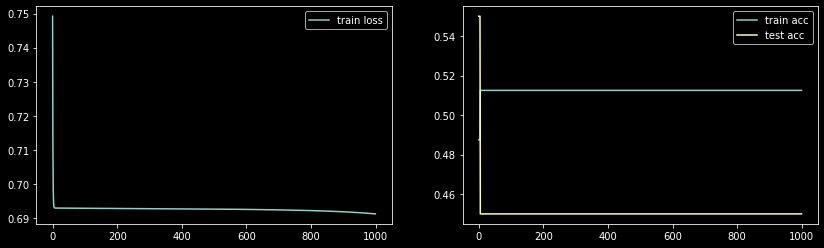

In [309]:
neural_network.fit(X_train, X_test, y_train, y_test)

In [189]:
neural_network.parametres

{'params1': {'W': array([[ 0.72921104,  1.92042672],
         [ 0.42681962,  0.39566733],
         [ 0.06524421, -0.54090745]]),
  'b': array([[-0.14199146],
         [-0.38993175],
         [-0.03395824]])},
 'params2': {'W': array([[-1.92036579,  0.84557038,  2.08861187],
         [-1.52767535,  0.03026915, -0.56412426],
         [-0.72303384,  1.36134964, -1.17936749]]),
  'b': array([[-1.79934003],
         [ 0.40668485],
         [ 0.34052797]])},
 'params3': {'W': array([[-0.53467863,  0.07435733,  0.2458617 ],
         [-0.62712728, -1.38226984, -1.35078054],
         [-0.0931085 ,  0.77277309, -0.50470113]]),
  'b': array([[-0.23777154],
         [-1.49271021],
         [ 0.875081  ]])},
 'params4': {'W': array([[ 0.31416142,  0.21929787, -0.26343847],
         [ 1.7897116 ,  1.77894678,  0.68999064]]),
  'b': array([[2.0727285 ],
         [1.47618484]])},
 'params5': {'W': array([[-0.85504174,  0.03848911]]),
  'b': array([[0.72027662]])}}

## Cat Vs Dog

In [9]:
from utilities import *


In [19]:
X_train, y_train, X_test, y_test = load_data()


C:\Users\Oumar Kane\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


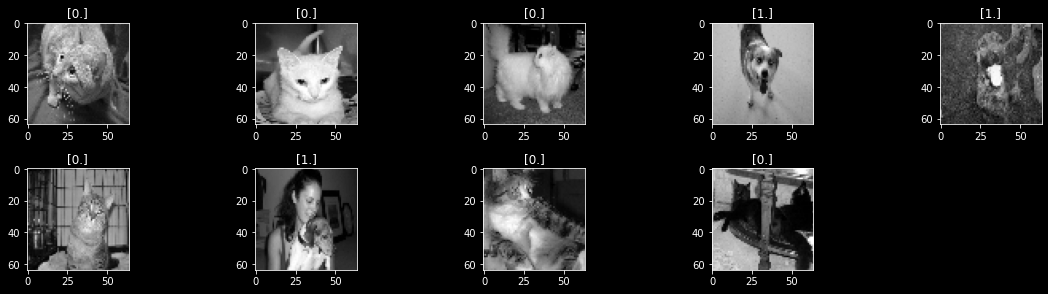

In [20]:
plt.figure(figsize=(16, 8))
for i in range(1, 10):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 64, 64)
(200, 64, 64)
(1000, 1)
(200, 1)


In [22]:
y_train = y_train.T
y_test = y_test.T

In [23]:
X_train = X_train.T
X_train_reshape = X_train.reshape(-1, X_train.shape[-1])/X_train.max()

X_test = X_test.T
X_test_reshape = X_test.reshape(-1, X_test.shape[-1])/X_test.max()

m_train = 300
m_test = 80
X_test_reshape = X_test_reshape[:, :m_test]
X_train_reshape = X_train_reshape[:, :m_train]
y_train = y_train[:, :m_train]
y_test = y_test[:, :m_test]

print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(y_train.shape)
print(y_test.shape)

(4096, 300)
(4096, 80)
(1, 300)
(1, 80)


In [24]:
neural_network_c_d = NeuralNetwork({"hidden_layers": [40, 30]}, epochs = 10000)

In [25]:
# parametres1 = neural_network(
#     X_train_reshape, y_train, X_test_reshape, y_test,
#     n1 = 32, learning_rate=0.01, n_iter=8000
# )

100%|██████████| 10000/10000 [04:22<00:00, 38.15it/s]


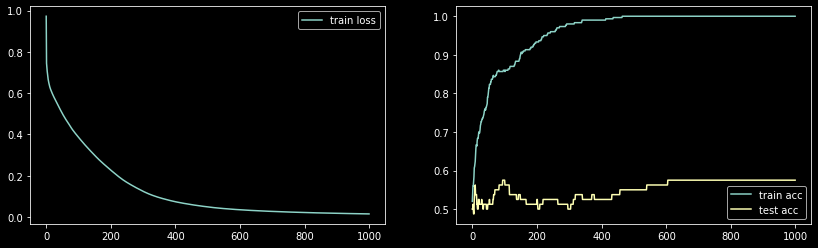

In [26]:
neural_network_c_d.fit(X_train_reshape, X_test_reshape, y_train, y_test)